<a href="https://colab.research.google.com/github/Hamz-sh/Hamz-sh-Fire-detection-CNN-/blob/main/my_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


!unzip /content/drive/MyDrive/Fire-Detection.zip
data_dir = '/content/Fire-Detection'

Archive:  /content/drive/MyDrive/Fire-Detection.zip
   creating: Fire-Detection/test/
   creating: Fire-Detection/test/0/
  inflating: Fire-Detection/test/0/1.jpg  
  inflating: Fire-Detection/test/0/2.jpg  
  inflating: Fire-Detection/test/0/3.jpg  
  inflating: Fire-Detection/test/0/4.jpg  
  inflating: Fire-Detection/test/0/407.jpg  
  inflating: Fire-Detection/test/0/408.jpg  
  inflating: Fire-Detection/test/0/409.jpg  
  inflating: Fire-Detection/test/0/410.jpg  
  inflating: Fire-Detection/test/0/411.jpg  
  inflating: Fire-Detection/test/0/412.jpg  
  inflating: Fire-Detection/test/0/413.jpg  
  inflating: Fire-Detection/test/0/414.jpg  
  inflating: Fire-Detection/test/0/415.jpg  
  inflating: Fire-Detection/test/0/416.JPG  
  inflating: Fire-Detection/test/0/417.JPG  
  inflating: Fire-Detection/test/0/418.jpg  
  inflating: Fire-Detection/test/0/419.jpg  
  inflating: Fire-Detection/test/0/420.jpg  
  inflating: Fire-Detection/test/0/421.jpg  
  inflating: Fire-Detection/tes

In [2]:
test_path = data_dir+'/test'
train_path = data_dir+'/train'
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  seed=123,
  image_size=(668, 922), batch_size=32)

val_ds = tf.keras.utils.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(668, 922), batch_size=1)

Found 1493 files belonging to 2 classes.
Found 605 files belonging to 2 classes.


In [3]:
# showing an image
dim1 = []
dim2 = []
for xyz in os.listdir(test_path+'/1'):
    fire = test_path + '/1/' + xyz
    img = imread(fire, 0)
    d1, d2, colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

print(np.mean(dim1))
print(np.mean(dim2))

667.78
921.7314285714285


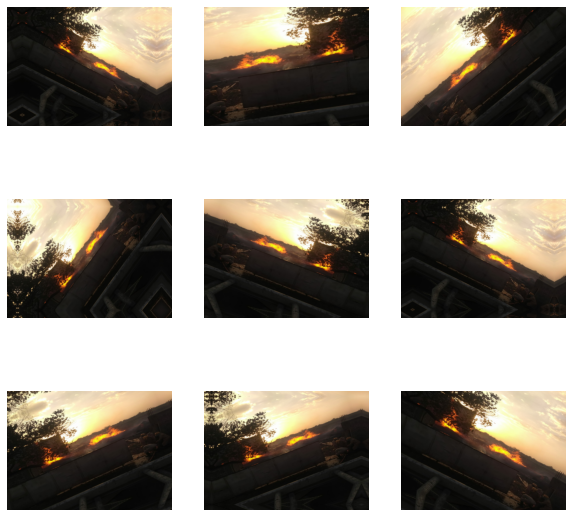

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([layers.RandomFlip("horizontal", input_shape= (668, 922, 3)), layers.RandomRotation(0.2), layers.RandomZoom(0.3)])

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [6]:
# resizing the images by taking the average size of the images
image_shape = (668, 922, 3)
batch_size = 32


# random image transformations
image_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
                               height_shift_range=0.1, shear_range=0.1,
                               zoom_range=0.1, fill_mode='nearest',
                               rescale=1/255)
train_gen = image_gen.flow_from_directory(train_path,
                                          target_size=image_shape[:2], color_mode='rgb',
                                          batch_size=batch_size, class_mode='binary')
print(train_gen)
test_gen = image_gen.flow_from_directory(test_path,
                                         target_size=image_shape[:2], color_mode='rgb',
                                         batch_size=batch_size, class_mode='binary', shuffle=False)
print(test_gen)


# Building model

model = Sequential(data_augmentation)

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1,2),input_shape=image_shape, activation='relu', padding='SAME'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=image_shape, activation='relu', padding='SAME'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=image_shape, activation='relu', padding='SAME'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=image_shape, activation='relu', padding='SAME'))
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Found 1493 images belonging to 2 classes.
Found 605 images belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 668, 922, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 668, 461, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 334, 230, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 334, 230, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 167, 115, 128)    0         
 2D)                                                             
                                     

In [7]:
# Training model
callbacks = EarlyStopping(monitor = 'val_loss',patience = 10, restore_best_weights=True)
results = model.fit(train_ds, validation_data=val_ds, epochs = 30, batch_size = 32, callbacks = callbacks)

Epoch 1/30


KeyboardInterrupt: ignored

In [8]:
md = pd.DataFrame(results.history)
plt.plot(md[['loss','val_loss']])
plt.show()
len(val_ds)

NameError: ignored

In [9]:
pred = model.predict(val_ds)
predictions = pred > 0.5


605/605 [==============================] - 13s 20ms/step


In [10]:
from sklearn.metrics import classification_report, confusion_matrix
test_gen.classes
print(classification_report(test_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       255
           1       0.58      1.00      0.73       350

    accuracy                           0.58       605
   macro avg       0.29      0.50      0.37       605
weighted avg       0.33      0.58      0.42       605



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


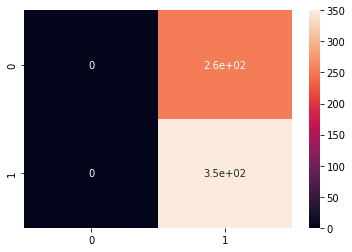

In [11]:
confusion_matrix(test_gen.classes,predictions)
sns.heatmap(confusion_matrix(test_gen.classes,predictions), annot=True)

In [12]:
model.save('my_model_n.h5')

'/content'